In [13]:
pip install torchinfo fvcore pyngrok wandB PyWavelets brevitas onnx onnxoptimizer pandas matplotlib scikit-learn seaborn imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
from imblearn.over_sampling import SMOTE
import wandb
import pywt

import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat
from brevitas.quant import Int8ActPerTensorFloat

# Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
# --- Data preprocessing & loading with SMOTE ---

AMII_CLASSES = ['N', 'S', 'V', 'F', 'Q']
num_classes = len(AMII_CLASSES)

def apply_dwt_denoising(ecg_signal, wavelet='db4', level=4):
    """
    Apply Discrete Wavelet Transform (DWT) for denoising ECG signals.

    Parameters:
    - ecg_signal: Raw ECG signal as a 1D NumPy array.
    - wavelet: The wavelet function (default = 'db4' for ECG signals).
    - level: The number of decomposition levels (default = 4).

    Returns:
    - Denoised ECG signal.
    """
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)  # Decompose signal
    coeffs[1:] = [pywt.threshold(c, np.std(c) * 0.5, mode="soft") for c in coeffs[1:]]  # Threshold details
    return pywt.waverec(coeffs, wavelet)[:len(ecg_signal)]  # Reconstruct & trim

def load_data(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
        return None, None, None

    # --- Normalize ECG Signal ---
    ecg_sig = (df['MLII'].values.astype(np.float32) - np.mean(df['MLII'])) / np.std(df['MLII'])

    # --- Apply DWT for Denoising ---
    ecg_sig = apply_dwt_denoising(ecg_sig)  # 🔹 DWT applied here

    # Extract labeled events (R-peaks)
    label_series = df[df['Type'] != '-'][['Sample', 'Type']]
    r_peaks = label_series['Sample'].values.astype(int)

    return ecg_sig, label_series, r_peaks



class ECGDataset(Dataset):
    def __init__(self, data_dir, beat_length=256, stride=1, apply_smote=True):
        """
        ECG Dataset with optional SMOTE balancing.

        Parameters:
        - data_dir: Path to the dataset folder.
        - beat_length: Fixed number of samples per beat.
        - stride: Step size for moving the window.
        - apply_smote: Boolean flag to apply SMOTE for data balancing.
        """
        super(ECGDataset, self).__init__()
        self.data_dir = data_dir
        self.beat_length = beat_length
        self.stride = stride
        self.apply_smote = apply_smote
        self.data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
        self.labeled_events = []  # Store ECG segments with filenames

        self.label_map = {label: index for index, label in enumerate(AMII_CLASSES)}
        print(self.label_map)
        self.class_counts = {label: 0 for label in AMII_CLASSES}  # Debugging class count

        for csv_file in self.data_files:
            ecg_sig, label_series, r_peaks = load_data(os.path.join(data_dir, csv_file))
            if ecg_sig is not None and len(r_peaks) > 0:
                for index, row in label_series.iterrows():
                    sample_number = int(row['Sample'])
                    label = self.label_map.get(row['Type'], -1)

                    if label != -1:
                        ecg_window = self.get_fixed_beat(ecg_sig, r_peaks, sample_number)

                        if ecg_window is not None:
                            self.labeled_events.append((csv_file, ecg_window, label))
                            self.class_counts[AMII_CLASSES[label]] += 1

        print(f"Initial class distribution: {self.class_counts}")

        # Apply SMOTE for balancing if enabled
        if self.apply_smote:
            self.apply_smote_balancing()

        # Convert dataset to PyTorch tensors
        self.labeled_events = [(f, torch.tensor(sig).float(), torch.tensor(lbl).long()) for f, sig, lbl in self.labeled_events]

    def get_fixed_beat(self, ecg_sig, r_peaks, sample_number):
        peak_idx = np.where(r_peaks == sample_number)[0]

        if len(peak_idx) == 0 or peak_idx[0] == 0 or peak_idx[0] >= len(r_peaks) - 1:
            return None  # Skip if at the boundary

        peak_idx = peak_idx[0]
        start_idx = r_peaks[peak_idx - 1]
        end_idx = r_peaks[peak_idx + 1]

        ecg_beat = ecg_sig[start_idx:end_idx]
        return self.resample_ecg(ecg_beat, self.beat_length)

    def resample_ecg(self, ecg_segment, target_length=256):
        if len(ecg_segment) == target_length:
            return ecg_segment
        return scipy.signal.resample(ecg_segment, target_length)

    def apply_smote_balancing(self):
        """
        Uses SMOTE to generate synthetic samples for the minority classes.
        """
        print("Applying SMOTE for class balancing...")

        # Extract features (beats) and labels
        X = np.array([sig for _, sig, _ in self.labeled_events])
        y = np.array([lbl for _, _, lbl in self.labeled_events])

        # Flatten ECG beats to 1D (necessary for SMOTE)
        X_flattened = X.reshape(X.shape[0], -1)  # Shape: (num_samples, beat_length)

        # Apply SMOTE
        smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
        X_resampled, y_resampled = smote.fit_resample(X_flattened, y)

        # Reshape back to original form
        X_resampled = X_resampled.reshape(X_resampled.shape[0], self.beat_length)

        # Update labeled events
        self.labeled_events = [(None, x, int(y)) for x, y in zip(X_resampled, y_resampled)]

        # Update class counts
        new_class_counts = {label: np.sum(y_resampled == idx) for label, idx in self.label_map.items()}
        print(f"New class distribution after SMOTE: {new_class_counts}")

    def __len__(self):
        return len(self.labeled_events)

    def __getitem__(self, idx):
        _, ecg_beat, label = self.labeled_events[idx]
        ecg_beat = ecg_beat.unsqueeze(0).unsqueeze(0)  # Add channel dimension for CNN
        return ecg_beat, label

In [25]:
# --- Load Data ---
csv_file_dir = '/home/eveneiha/ArrDetFPGA/src/ml/data/mitDB_AMII'
full_dataset = ECGDataset(csv_file_dir)

{'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
Initial class distribution: {'N': 89012, 'S': 2772, 'V': 7176, 'F': 802, 'Q': 6781}
Applying SMOTE for class balancing...
New class distribution after SMOTE: {'N': 89012, 'S': 89012, 'V': 89012, 'F': 89012, 'Q': 89012}


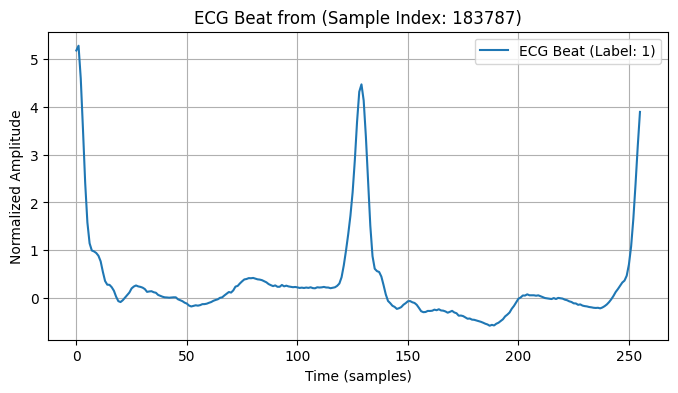

In [26]:
# plot to viz
# Select a random index from the dataset
sample_idx = np.random.randint(0, len(full_dataset))

# Fetch the sample
ecg_sample, label = full_dataset[sample_idx]

# Convert to numpy for plotting
ecg_sample_np = ecg_sample.squeeze().numpy()  # Remove channel dimension

# Plot the ECG beat
plt.figure(figsize=(8, 4))
plt.plot(ecg_sample_np, label=f"ECG Beat (Label: {label.item()})")
plt.title(f"ECG Beat from (Sample Index: {sample_idx})")
plt.xlabel("Time (samples)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
class QuantizedTemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(QuantizedTemporalBlock2d, self).__init__()
        # Convert Conv1d to Conv2d:
        # - The kernel is represented as (1, kernel_size)
        # - The stride as (1, stride)
        # - Padding as (0, padding)
        # - Dilation as (1, dilation)
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs, kernel_size=(1, kernel_size),  # Kernel shape for Conv2d
            stride=(1, stride), padding=(0, padding),
            dilation=(1, dilation),
            weight_quant=Int8WeightPerTensorFloat,
            bias=False)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs, kernel_size=(1, kernel_size),  # Kernel shape for Conv2d
            stride=(1, stride), padding=(0, padding),
            dilation=(1, dilation),
            weight_quant=Int8WeightPerTensorFloat,
            bias=False)
        self.dropout2 = nn.Dropout(dropout)

        # For layer norm, we need to operate on the channel dimension.
        self.chan_norm1 = nn.LayerNorm(n_outputs)
        self.chan_norm2 = nn.LayerNorm(n_outputs)
        self.relu = nn.ReLU()

        # If dimensions mismatch, downsample the residual.
        if n_inputs != n_outputs:
            self.downsample = qnn.QuantConv2d(
                n_inputs, n_outputs, kernel_size=(1, 1),  # Kernel shape for downsampling
                weight_quant=Int8WeightPerTensorFloat)
        else:
            self.downsample = None

    def forward(self, x):
        # x: [batch, channels, 1, time]
        out = self.conv1(x)  # Expected shape: [batch, n_outputs, 1, new_time]
        # Layer norm expects shape [batch, time, channels], so we remove the dummy dim,
        # permute, apply norm, then put the dummy dim back.

        # Changed: Correctly permute dimensions for LayerNorm
        out = out.squeeze(2).permute(0, 2, 1)  # Shape: [batch, new_time, n_outputs]
        out = self.chan_norm1(out)
        out = out.permute(0, 2, 1).unsqueeze(2)  # Reshape back to [batch, n_outputs, 1, new_time]
        out = self.dropout1(out)

        out = self.conv2(out)
        # Changed: Correctly permute dimensions for LayerNorm
        out = out.squeeze(2).permute(0, 2, 1)  # Shape: [batch, new_time, n_outputs]
        out = self.chan_norm2(out)
        out = out.permute(0, 2, 1).unsqueeze(2)  # Reshape back to [batch, n_outputs, 1, new_time]
        out = self.relu(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        # Pad residual if needed
        if out.size(3) > res.size(3):
            diff = out.size(3) - res.size(3)
            res = torch.nn.functional.pad(res, (0, diff))

        # Ensure residual and output shapes are the same before adding
        if res.shape[2] < out.shape[2]:
            res = F.pad(res, (0, 0, 0, out.shape[2] - res.shape[2]))  # Pad height to match output
        elif res.shape[2] > out.shape[2]:
            out = F.pad(out, (0, 0, 0, res.shape[2] - out.shape[2]))  # Pad height to match residual

        return self.relu(out + res)  # Return the sum of output and residual


class QuantizedTCN2d(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels, kernel_size, dropout, dilation_factor):
        super(QuantizedTCN2d, self).__init__()
        self.num_channels = num_channels
        self.temporal_blocks = nn.ModuleList()

        for i in range(len(num_channels)):
            dilation_size = dilation_factor ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            # For conv2d, padding becomes (0, (kernel_size-1)*dilation)
            padding = (kernel_size - 1) * dilation_size
            self.temporal_blocks.append(
                QuantizedTemporalBlock2d(in_channels, out_channels, kernel_size, stride=1,
                                           dilation=dilation_size, padding=padding, dropout=dropout))

        self.fc = qnn.QuantLinear(num_channels[-1], num_outputs, weight_quant=Int8WeightPerTensorFloat)

    def forward(self, x):
        # x: [batch, channels, 1, time]
        for block in self.temporal_blocks:
            x = block(x)
        # Average over the time dimension (dim 3)
        x = x.mean(dim=3, keepdim=True)  # [batch, channels, 1, 1]
        x = x.squeeze(3).squeeze(2)       # [batch, channels]
        x = self.fc(x)
        return x


class ExportWrapper(nn.Module):
    def __init__(self, model):
        super(ExportWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # x: [batch, channels, time]
        # Add dummy spatial dimension so that x becomes [batch, channels, 1, time]
        x = x.unsqueeze(2)
        return self.model(x)


In [27]:
# --- Model Config ---
input_channels = 1      # 1 ECG channel
num_channels = [4, 8, 16]  # Number of channels at each block
output_channels = 5     # e.g., number of classes
kernel_size = 5
dilation_factor = 4
dropout = 0.074
lr = 0.008
batch_size = 256

# Instantiate the modified model
tcn = QuantizedTCN2d(input_channels, output_channels, num_channels, kernel_size, dropout, dilation_factor)

dummy_input = torch.randn(1, 1, 1, 256)  # Adjust dimensions if needed
tcn(dummy_input)

optimizer = optim.Adam(tcn.parameters(), lr=lr)

# Print model summary
summary(tcn, input_size=(1, 1, 1, 256))  # (batch_size, channels, sequence_length)

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


Layer (type:depth-idx)                                                 Output Shape              Param #
QuantizedTCN2d                                                         [1, 5]                    --
├─ModuleList: 1-1                                                      --                        --
│    └─QuantizedTemporalBlock2d: 2-1                                   [1, 4, 1, 264]            --
│    │    └─QuantConv2d: 3-1                                           [1, 4, 1, 260]            20
│    │    └─LayerNorm: 3-2                                             [1, 260, 4]               8
│    │    └─Dropout: 3-3                                               [1, 4, 1, 260]            --
│    │    └─QuantConv2d: 3-4                                           [1, 4, 1, 264]            80
│    │    └─LayerNorm: 3-5                                             [1, 264, 4]               8
│    │    └─ReLU: 3-6                                                  [1, 4, 1, 264]            

In [28]:
# Split training, validation and testing

train_size = 0.7
val_size = 0.15
test_size = 0.15
loss_function = "label_smoothing"
# Stratified Data Split (with reduced size)
labels = [label.item() for _, label  in full_dataset]

# First, split train + temp (validation+test)
train_idx, temp_idx = train_test_split(
    list(range(len(full_dataset))), test_size=1 - train_size, stratify=labels, random_state=42)

# Get labels for second split (validation/test)
temp_labels = [labels[i] for i in temp_idx]

val_idx, test_idx = train_test_split(
    temp_idx, test_size=test_size/(test_size + val_size), stratify=temp_labels, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

test_labels = [label.item() for _, label in test_dataset]
print("Unique labels in test set:", set(test_labels))


# Calculate class weights
labels = []
for _,label in full_dataset:
  labels.append(label)
class_counts = torch.bincount(torch.stack(labels))
class_weights = 1.0 / (class_counts + 1e-7)
print("Class Weights: ", class_weights)


# --- Define Loss and Optimizer ---
# --- Select Loss Function ---
if loss_function == "cross_entropy":
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
elif loss_function == "label_smoothing":
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)

Unique labels in test set: {0, 1, 2, 3, 4}
Class Weights:  tensor([1.1234e-05, 1.1234e-05, 1.1234e-05, 1.1234e-05, 1.1234e-05])


In [29]:
# ---------------------- Training Parameters ----------------------
num_epochs = 5  # number of training loops over the training dataset

# Lists for plotting Loss
training_losses = []
validation_losses = []


# --- Logging with wandB ---
wandb.init(project="tcn_experiments")

wandb.config.num_channels = num_channels
wandb.config.kernel_size = kernel_size
wandb.config.dropout = dropout
wandb.config.batch_size = batch_size
wandb.config.learning_rate = lr


# ---------------------- Training Loop ----------------------
tcn.train()
tcn.to(device) # Transfer model to GPU

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    total_loss = 0
    batch_num = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        #Transfer data to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        #Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = tcn(inputs) # apply the TCN to the input
        # Calculate the loss
        loss = criterion(outputs, targets)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        running_loss += loss.item() # update running loss
        _, predicted = torch.max(outputs, 1) # get the class prediction
        running_correct += (predicted == targets).sum().item() # update running correct

        # Log the progress
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
            # writer.add_scalar("Training loss", running_loss / 100 , epoch * len(train_dataloader) + batch_idx)
            # writer.add_scalar("Accuracy", running_correct / 100 , epoch * len(train_dataloader) + batch_idx)
            running_loss = 0.0
            running_correct = 0

        total_loss += loss.item() # update total loss
        batch_num+=1

    training_loss_avg = total_loss / batch_num
    training_losses.append(training_loss_avg) # append training loss to the list
    # writer.add_scalar("Loss/Train", training_loss_avg, epoch)

    train_loss = total_loss / len(train_dataloader)

    # --- Validation ---
    tcn.eval()  
    total_loss_val = 0
    batch_num_val = 0
    correct, total = 0, 0  

    with torch.no_grad():
        for batch_idx_val, (inputs_val, targets_val) in enumerate(val_dataloader):
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            outputs_val = tcn(inputs_val)

            # Calculate loss
            loss_val = criterion(outputs_val, targets_val)
            total_loss_val += loss_val.item()
            batch_num_val += 1

            # Accuracy Calculation
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss_avg = total_loss_val / batch_num_val
    validation_losses.append(val_loss_avg)

    # Compute Validation Accuracy
    val_acc = correct / total

    # 🔹 Print validation results
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.4f}")
    tcn.train()

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch: 1/5, Batch: 0/1217, Loss: 1.6256
Epoch: 1/5, Batch: 100/1217, Loss: 1.3975
Epoch: 1/5, Batch: 200/1217, Loss: 1.0454
Epoch: 1/5, Batch: 300/1217, Loss: 0.9663
Epoch: 1/5, Batch: 400/1217, Loss: 0.8477
Epoch: 1/5, Batch: 500/1217, Loss: 0.8736
Epoch: 1/5, Batch: 600/1217, Loss: 0.8305
Epoch: 1/5, Batch: 700/1217, Loss: 0.8311
Epoch: 1/5, Batch: 800/1217, Loss: 0.8127
Epoch: 1/5, Batch: 900/1217, Loss: 0.7118
Epoch: 1/5, Batch: 1000/1217, Loss: 0.7532
Epoch: 1/5, Batch: 1100/1217, Loss: 0.7264
Epoch: 1/5, Batch: 1200/1217, Loss: 0.7328
Epoch 1/5: Train Loss=0.9047, Val Loss=0.6677, Val Acc=0.8851
Epoch: 2/5, Batch: 0/1217, Loss: 0.7864
Epoch: 2/5, Batch: 100/1217, Loss: 0.6959
Epoch: 2/5, Batch: 200/1217, Loss: 0.6432
Epoch: 2/5, Batch: 300/1217, Loss: 0.6571
Epoch: 2/5, Batch: 400/1217, Loss: 0.7143
Epoch: 2/5, Batch: 500/1217, Loss: 0.6236
Epoch: 2/5, Batch: 600/1217, Loss: 0.6730
Epoch: 2/5, Batch: 700/1217, Loss: 0.6539
Epoch: 2/5, Batch: 800/1217, Loss: 0.6631
Epoch: 2/5, Bat

Test Loss: 0.5564, Test Accuracy: 0.9419


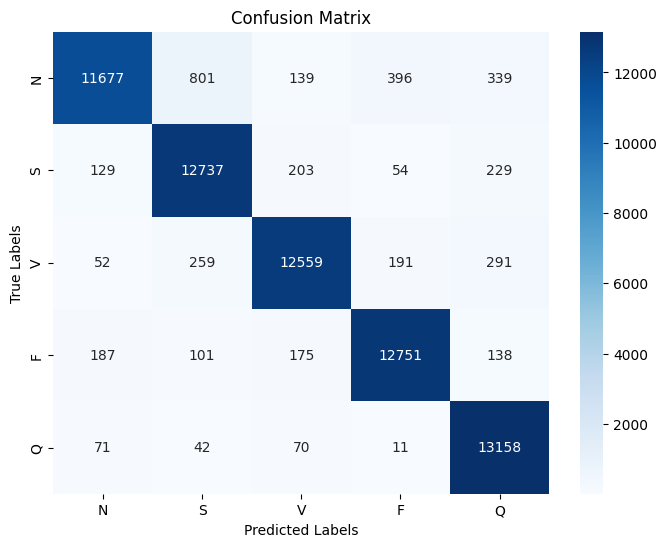

Unique values in all_targets: [0 1 2 3 4]
Unique values in all_preds: [0 1 2 3 4]
Classification Report:
               precision    recall  f1-score   support

           N       0.96      0.87      0.92     13352
           S       0.91      0.95      0.93     13352
           V       0.96      0.94      0.95     13352
           F       0.95      0.95      0.95     13352
           Q       0.93      0.99      0.96     13352

    accuracy                           0.94     66760
   macro avg       0.94      0.94      0.94     66760
weighted avg       0.94      0.94      0.94     66760



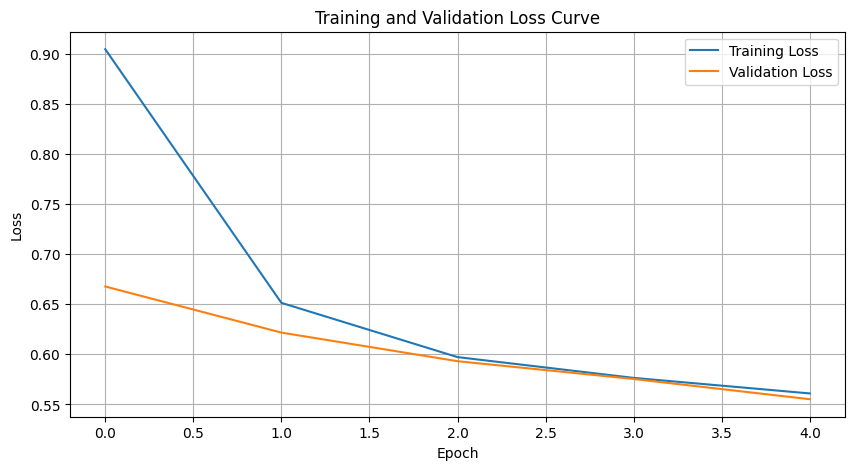

📊 **Total Macro F1-Score**: 0.9416
📊 **Total Weighted F1-Score**: 0.9416


In [30]:
# --- Evaluation ---

tcn.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_loss = 0
correct, total = 0, 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = tcn(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1) # get the class prediction
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        all_preds.extend(predicted.cpu().numpy()) # store predictions
        all_targets.extend(targets.cpu().numpy()) # store target labels

test_loss /= len(test_dataloader)
test_accuracy = correct / total

# wandb.run.summary["Final test_loss"] = test_loss
# wandb.run.summary["Finnal test_accuracy"] = test_accuracy
# wandb.finish()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=AMII_CLASSES, yticklabels=AMII_CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Unique values in all_targets:", np.unique(all_targets))
print("Unique values in all_preds:", np.unique(all_preds))


# Generate classification report
print("Classification Report:\n", classification_report(all_targets, all_preds, target_names=AMII_CLASSES, zero_division=0))

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), training_losses, label='Training Loss')
plt.plot(range(num_epochs), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Compute Total F1-Scores ---
macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 **Total Macro F1-Score**: {macro_f1:.4f}")

print(f"📊 **Total Weighted F1-Score**: {weighted_f1:.4f}")




In [31]:
# --- Save model ---
torch.save({
    'model_state_dict': tcn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, '/home/eveneiha/ArrDetFPGA/src/ml/tcn_model.pth')

print("Training Done, model weights are saved")



Training Done, model weights are saved


In [33]:

# CPU:
checkpoint = torch.load('/home/eveneiha/ArrDetFPGA/src/ml/tcn_model.pth', map_location=torch.device('cpu'))


# GPU
# checkpoint = torch.load('/content/drive/MyDrive/Master/tcn_model_v9.pth')
tcn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
tcn.eval()


/tmp/ipykernel_1811592/2001014206.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/eveneiha/ArrDetFPGA/src/ml/tcn_model.pth', map_location=

QuantizedTCN2d(
  (temporal_blocks): ModuleList(
    (0): QuantizedTemporalBlock2d(
      (conv1): QuantConv2d(
        1, 4, kernel_size=(1, 5), stride=(1, 1), padding=(0, 4), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
        )
        (output_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
        )
        (weight_quant): WeightQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClampSte()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
              (input_view_impl): Identity()
            )
            (scaling_impl): StatsFromParameterScaling(
              (parameter_list_stats): _ParameterListStats(
                (first_tracked_param):

In [35]:

# #wrapped_model = ExportWrapper(tcn)
# dummy_input = torch.randn(256, 1, 1, 256).to(device)  # Shape must match your input
# torch.onnx.export(
#     wrapped_model,
#     dummy_input,
#     "tcn_model_v17.onnx",
#     opset_version=11,
#     export_params=True,
#     do_constant_folding=False,  # Debugging step
#     keep_initializers_as_inputs=True,  # Recommended for FINN
#     input_names=["quant_input"],
#     output_names=["quant_output"],
#     dynamic_axes={"quant_input": {0: "batch_size"}, "quant_output": {0: "batch_size"}},
#     verbose=True
# )
tcn.eval()
wrapped_model = ExportWrapper(tcn)

dummy_input = torch.randn(1, 1, 1, 256).to(device)
torch.onnx.export(
    tcn,
    dummy_input,
    "/home/eveneiha/ArrDetFPGA/src/ml/model.onnx",
    opset_version=11,
    export_params=True,
    do_constant_folding=True,  # Enable constant folding if possible
    keep_initializers_as_inputs=True,
    input_names=["quant_input"],
    output_names=["quant_output"],
    dynamic_axes={}  # Do not set dynamic axes, or explicitly set them to fixed values
)


/tmp/ipykernel_1811592/3210170780.py:60: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if out.size(3) > res.size(3):
/tmp/ipykernel_1811592/3210170780.py:65: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if res.shape[2] < out.shape[2]:
/tmp/ipykernel_1811592/3210170780.py:67: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif res.shape